<a href="https://colab.research.google.com/github/danielray54/DeepPulse/blob/main/DeepPulse_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPulse Training

In [ ]:
!pip install pickle5

In [ ]:
#Import Necessary Packages
import pickle5
import tensorflow_probability as tfp 
tfd = tfp.distributions
import os
import tensorflow as tf
import tensorflow.keras as keras
import random
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import scipy.signal as sci_sig
from scipy import stats
import numpy as np
from sklearn import preprocessing 

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Built with CUDA: ", tf.test.is_built_with_cuda())
print("CPUs: ", tf.config.list_physical_devices('CPU'))
print("GPUs: ", tf.config.list_physical_devices('GPU'))

Tensorflow Version:  2.7.0
Built with CUDA:  True
CPUs:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-01-07 05:55:33.609186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 05:55:33.719392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 05:55:33.720291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sci_sig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sci_sig.lfilter(b, a, data)
    return y

def resample_signal(signal_data, curr_fs, new_fs):
    num_secs_in_signal = len(signal_data)/curr_fs 
    num_samples_to_resample = round(num_secs_in_signal*new_fs)  
    return sci_sig.resample(signal_data, num_samples_to_resample)

def slidingWindow(sequence,winSize,step=1):
    """Returns a generator that will iterate through the defined chunks of input sequence. Input sequence must be sliceable."""

    # Verify the inputs
    if not ((type(winSize) == type(0)) and (type(step) == type(0))):
        raise Exception("**ERROR** type(winSize) and type(step) must be int.")
    if step > winSize:
        raise Exception("**ERROR** step must not be larger than winSize.") 
    if winSize > len(sequence):
        raise Exception("**ERROR** winSize must not be larger than sequence length.")

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
    # Do the work
    for i in range(0,int(numOfChunks)*step,step):
        yield sequence[i:i+winSize]

def preprocess(signal_data, fs):
  filtr_sig = butter_bandpass_filter(signal_data, 0.5, 4.5, fs, order=2)
  filtd_sig_resample = resample_signal(filtr_sig, fs, 64)
  normalise_sig = stats.zscore(filtd_sig_resample)
  return normalise_sig

def flatten(t):
    return [item for sublist in t for item in sublist]

def split_list(alist, wanted_parts=1):     
  length = len(alist)     
  return [alist[i*length // wanted_parts: (i+1)*length // wanted_parts]  for i in range(wanted_parts)]

def loso(data):
  SUBJECT = list(range(len(data)))
  random.shuffle(SUBJECT, random.random)
  FOLDS = len(SUBJECT)//3
  sub_folds = split_list(SUBJECT, wanted_parts=FOLDS)
  train_set = []
  val_set = []
  test_set = []
  for x in range(len(sub_folds)):
    train_val_test = sub_folds
    val_test = train_val_test[x]
    train = [num for num in train_val_test if num != val_test]
    train = flatten(train)
    for z in range(len(val_test)):
      test = val_test[z]
      val = [num for num in val_test if num != test]
      train = random.sample(train, len(train))
      train_set.append(train)
      val_set.append(val)
      test_set.append([test])
  return train_set, val_set, test_set


In [ ]:
infile = open("/home/jupyter/DaLia_Data",'rb')
DaLia_Data = pickle5.load(infile)
infile.close()
infile = open("/home/jupyter/BAMI_Data",'rb')
BAMI_Data = pickle5.load(infile)
infile.close()
infile = open("/home/jupyter/IEEE_Train_Data",'rb')
IEEE_Train_Data = pickle5.load(infile)
infile.close()
infile = open("/home/jupyter/IEEE_Test_Data",'rb')
IEEE_Test_Data = pickle5.load(infile)
infile.close()
IEEE_Data = IEEE_Train_Data + IEEE_Test_Data

In [ ]:
def preprocess_dataset(dataset):
  preprocessed_inputs_ACC = []
  preprocessed_inputs_PPG = []
  truth = []
  fs_dataset_PPG = dataset[0]["PPG_fs"]
  fs_dataset_ACC = dataset[0]["ACC_fs"]
  for idx, subject in enumerate(range(len(dataset))):
    ppg1_signal_windowed = []
    accx_signal_windowed = []
    accy_signal_windowed = []
    accz_signal_windowed = []

    #---------------PPG------------------------------------------
    ppg_signal = preprocess(dataset[subject]["Raw_PPG_1"], fs_dataset_PPG)
    for i in slidingWindow(ppg_signal, 8*64, 2*64):
      ppg1_signal_windowed.append(i)

    accx_signal = preprocess(dataset[subject]["Raw ACC_X"], fs_dataset_ACC)
    for i in slidingWindow(accx_signal, 8*64, 2*64):
      accx_signal_windowed.append(i)

    accy_signal = preprocess(dataset[subject]["Raw ACC_Y"], fs_dataset_ACC)
    for i in slidingWindow(accy_signal, 8*64, 2*64):
      accy_signal_windowed.append(i)

    accz_signal = preprocess(dataset[subject]["Raw ACC_Z"], fs_dataset_ACC)
    for i in slidingWindow(accz_signal, 8*64, 2*64):
      accz_signal_windowed.append(i)

    truth.append(dataset[subject]["truth_values"])
    
    ppg1_signal_windowed = np.array(ppg1_signal_windowed)
    accx_signal_windowed = np.array(accx_signal_windowed)
    accy_signal_windowed = np.array(accy_signal_windowed)
    accz_signal_windowed = np.array(accz_signal_windowed)

   
    acc_signals_stacked = np.stack((accx_signal_windowed,
                      accy_signal_windowed,accz_signal_windowed), axis=2)
    ppg1_signal_windowed = np.expand_dims(ppg1_signal_windowed, axis=2)
    preprocessed_inputs_ACC.append(acc_signals_stacked)
    preprocessed_inputs_PPG.append(ppg1_signal_windowed)
  return preprocessed_inputs_PPG, preprocessed_inputs_ACC, truth


In [ ]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

def logistic_sp(params): 
  return tfd.Logistic(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 *params[:,1:2]))# both parameters are learnable

In [ ]:
def make_DeepPulse():
  keras.backend.clear_session()
  DROP_RATE = 0.15
  m = 0.9
  MAX_POOL = True
  training_do = True
  paddingcnn = "same"
  input_PPG = keras.Input(shape=(512, 1), name="PPG_Sigs")
  input_ACC = keras.Input(shape=(512, 3), name="ACC_Sigs")
  
#=-==========================================================
  x = layers.Conv1D(
      64, 
      16, 
      use_bias=False,
      padding=paddingcnn)(input_PPG)
  x = layers.ReLU()(x)
  x = layers.BatchNormalization(momentum=m)(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(DROP_RATE)(x, training=training_do)
  
  x = layers.Conv1D(
      64, 
      16, 
      use_bias=False,
     padding=paddingcnn)(x)
  x = layers.ReLU()(x)
  x = layers.BatchNormalization(momentum=m)(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(DROP_RATE)(x, training=training_do)
  
#=-==========================================================

  y = layers.Conv1D(
      64, 
      16,
      use_bias=False,
      padding=paddingcnn)(input_ACC)
  y = layers.ReLU()(y)
  y = layers.BatchNormalization(momentum=m)(y)
  y = layers.MaxPool1D(2)(y)
  y = layers.Dropout(DROP_RATE)(y, training=training_do)
  
  y = layers.Conv1D(
      64, 
      16, 
      use_bias=False,
      padding=paddingcnn)(y)
  y = layers.ReLU()(y)
  y = layers.BatchNormalization(momentum=m)(y)
  y = layers.MaxPool1D(2)(y)
  y = layers.Dropout(DROP_RATE)(y, training=training_do)
  

#=-==========================================================
  x = layers.Concatenate(axis=2)([x, y])
#=-==========================================================
  
  x = layers.Conv1D(
      128, 
      16, 
      use_bias=False,
      padding=paddingcnn)(x)
  x = layers.ReLU()(x)
  x = layers.BatchNormalization(momentum=m)(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(DROP_RATE)(x, training=training_do)

  x = layers.Conv1D(
      128, 
      16,
      use_bias=False,
      padding=paddingcnn)(x)
  x = layers.ReLU()(x)
  x = layers.BatchNormalization(momentum=m)(x)
  x = layers.Dropout(DROP_RATE)(x, training=training_do)

#=-==========================================================
  x = layers.Bidirectional(layers.LSTM(32, time_major=False,
      return_sequences=True))(x) 
  x = layers.Bidirectional(layers.LSTM(32,  time_major=False,
      return_sequences=True))(x) 
#=-==========================================================

  x = layers.Conv1D(
       1, 
       16,
       padding=paddingcnn)(x)
  x = layers.ReLU()(x)
  
  x = layers.Flatten()(x)
 
  params = layers.Dense(2)(x)
  
  dist = tfp.layers.DistributionLambda(logistic_sp)(params)
  OPT = tf.optimizers.Nadam()
  DeepPulse = keras.Model(inputs = [input_PPG, input_ACC], outputs = dist, name="DeepPulse")
 # model_monotoic_sd_mean = keras.Model(inputs=[input_PPG, input_ACC], outputs=dist.mean())
  #model_monotoic_sd_sd = keras.Model(inputs=[input_PPG, input_ACC], outputs=dist.stddev())
  DeepPulse.compile(loss=NLL, optimizer=OPT, metrics = ['mae'])
  return DeepPulse

In [ ]:
make_DeepPulse().summary()

In [ ]:
def train_model_loso(DATASET, PPG_DATA, ACC_DATA, TRUTH, FOLDER):
  eval_res = []
  train_res = []
  val_res = []
  train_set_indexes, val_set_indexes, test_set_indexes = loso(DATASET)
  for fold in range(len(train_set_indexes)):
    train_PPG = [PPG_DATA[index] for index in train_set_indexes[fold]]
    train_PPG = np.concatenate(train_PPG, axis=0)

    train_ACC = [ACC_DATA[index] for index in train_set_indexes[fold]]
    train_ACC = np.concatenate(train_ACC, axis=0)

    train_truth = [TRUTH[index] for index in train_set_indexes[fold]]
    train_truth = np.concatenate(train_truth, axis=0)

    val_PPG = [PPG_DATA[valindex] for valindex in val_set_indexes[fold]]
    val_PPG = np.concatenate(val_PPG, axis=0)

    val_ACC = [ACC_DATA[valindex] for valindex in val_set_indexes[fold]]
    val_ACC = np.concatenate(val_ACC, axis=0)

    val_truth = [TRUTH[valindex] for valindex in val_set_indexes[fold]]
    val_truth = np.concatenate(val_truth, axis=0)

    test_PPG = [PPG_DATA[testindex] for testindex in test_set_indexes[fold]]
    test_PPG = np.concatenate(test_PPG, axis=0)

    test_ACC = [ACC_DATA[testindex] for testindex in test_set_indexes[fold]]
    test_ACC = np.concatenate(test_ACC, axis=0)

    test_truth = [TRUTH[testindex] for testindex in test_set_indexes[fold]]
    test_truth = np.concatenate(test_truth, axis=0)

    es=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=30,
                                     verbose=1,  restore_best_weights=True)
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        '/home/jupyter/'+str(FOLDER)+'/fold'+str(fold)+'.h5', 
        monitor='val_loss', verbose=1, 
        save_best_only=True, 
        mode='min')
    rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", 
                                                factor=0.5, patience=2,
                                                verbose=1)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/home/jupyter/"+str(FOLDER)+"_logs"+"/"+str(fold)+"/", histogram_freq=1)
    model = make_DeepPulse()
    print("Fit model on training data fold ", fold)
    history = model.fit(
        [train_PPG, train_ACC],
        train_truth,
        batch_size=32,
        epochs=200,
        validation_data=([val_PPG, val_ACC], val_truth),
            verbose=1,
          callbacks=[es, checkpoint_callback, rlronp, tensorboard_callback])
    model.load_weights('/home/jupyter/'+str(FOLDER)+'/fold'+str(fold)+'.h5')
    eval_history = model.evaluate(
        [test_PPG, test_ACC],
        test_truth,
        batch_size=32,verbose=1)
    train_res.append(history.history['mae'])
    val_res.append(history.history['val_mae'])
    eval_res.append([eval_history[1]]*len(history.history['mae']))
    
    del history
    del eval_history
    #model.save('/home/jupyter/'+str(FOLDER)+'/fold'+str(fold)+'.h5')  # creates a HDF5 file 'my_model.h5'
    del model  # deletes the existing model

  train_res = flatten(train_res)
  val_res = flatten(val_res)
  eval_res = flatten(eval_res)
  plt.figure(figsize=(30,10))
  plt.plot(train_res)
  plt.plot(val_res)
  plt.plot(eval_res)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation', 'test'], loc='upper left')
  #plt.yscale('log')
  #plt.ylim([0, 25])
  
  plt.show()
  print("Eval Mean", np.mean(eval_res))

Fit model on training data fold  0
Epoch 1/200
84/84 [==============================] - ETA: 0s - loss: 43.3337 - mae: 75.6397
Epoch 00001: val_loss improved from inf to 4.53871, saving model to /home/jupyter/IEEE/fold0.h5
84/84 [==============================] - 22s 134ms/step - loss: 43.3337 - mae: 75.6397 - val_loss: 4.5387 - val_mae: 21.0094 - lr: 0.0010
Epoch 2/200
84/84 [==============================] - ETA: 0s - loss: 5.1129 - mae: 25.2565
Epoch 00002: val_loss did not improve from 4.53871
84/84 [==============================] - 8s 89ms/step - loss: 5.1129 - mae: 25.2565 - val_loss: 4.8485 - val_mae: 20.6867 - lr: 0.0010
Epoch 3/200
84/84 [==============================] - ETA: 0s - loss: 4.5537 - mae: 20.8156
Epoch 00003: val_loss improved from 4.53871 to 4.49164, saving model to /home/jupyter/IEEE/fold0.h5
84/84 [==============================] - 8s 91ms/step - loss: 4.5537 - mae: 20.8156 - val_loss: 4.4916 - val_mae: 21.5726 - lr: 0.0010
Epoch 4/200
84/84 [=================

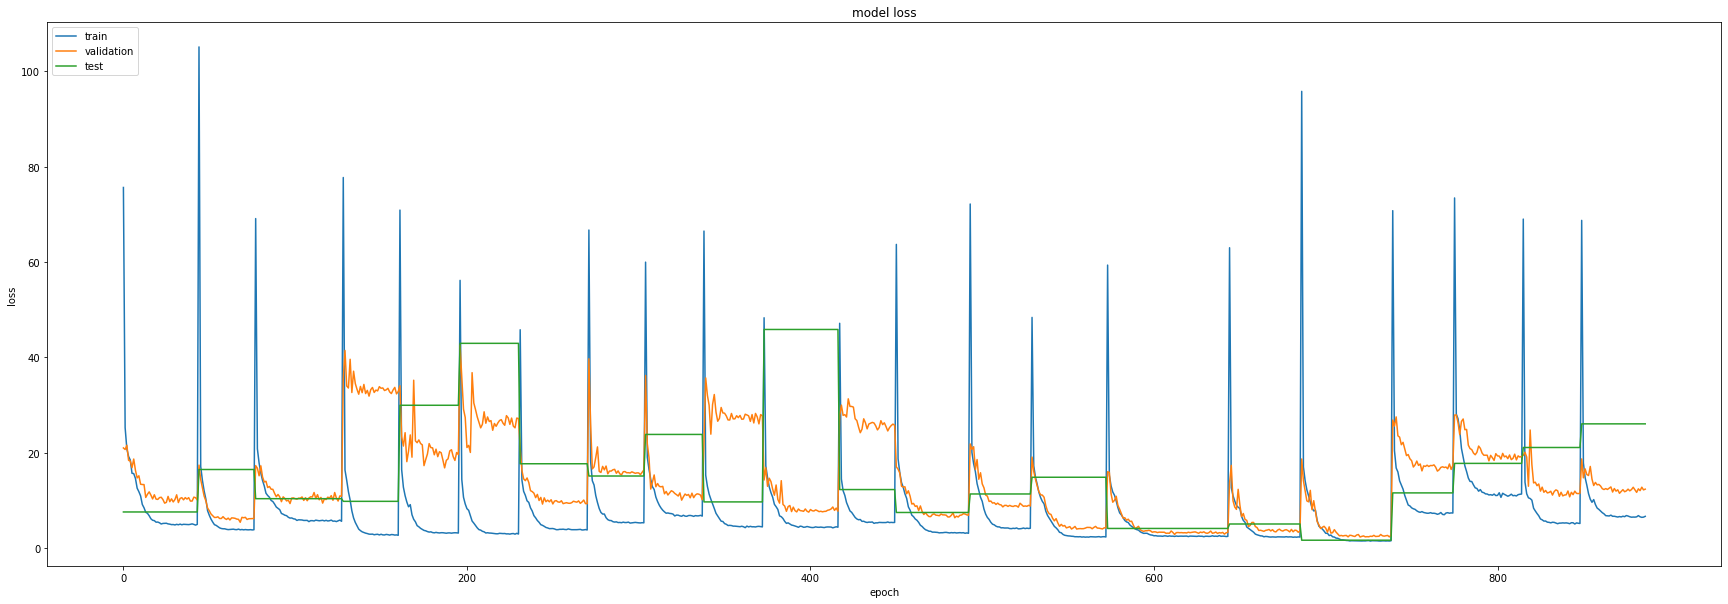

Eval Mean 15.643461589614326


In [ ]:
IEEE_Data_PPG, IEEE_Data_ACC, IEEE_Data_truth = preprocess_dataset(IEEE_Data)
train_model_loso(IEEE_Data, IEEE_Data_PPG, IEEE_Data_ACC, IEEE_Data_truth, "IEEE")

Fit model on training data fold  0
Epoch 1/200
238/238 [==============================] - ETA: 0s - loss: 26.5969 - mae: 27.3459
Epoch 00001: val_loss improved from inf to 3.86390, saving model to /home/jupyter/BAMI/fold0.h5
238/238 [==============================] - 34s 104ms/step - loss: 26.5969 - mae: 27.3459 - val_loss: 3.8639 - val_mae: 10.0977 - lr: 0.0010
Epoch 2/200
238/238 [==============================] - ETA: 0s - loss: 3.2564 - mae: 7.3044
Epoch 00002: val_loss improved from 3.86390 to 3.17298, saving model to /home/jupyter/BAMI/fold0.h5
238/238 [==============================] - 20s 86ms/step - loss: 3.2564 - mae: 7.3044 - val_loss: 3.1730 - val_mae: 6.4887 - lr: 0.0010
Epoch 3/200
238/238 [==============================] - ETA: 0s - loss: 3.0742 - mae: 5.9938
Epoch 00003: val_loss did not improve from 3.17298
238/238 [==============================] - 20s 84ms/step - loss: 3.0742 - mae: 5.9938 - val_loss: 3.7341 - val_mae: 8.0158 - lr: 0.0010
Epoch 4/200
238/238 [=======

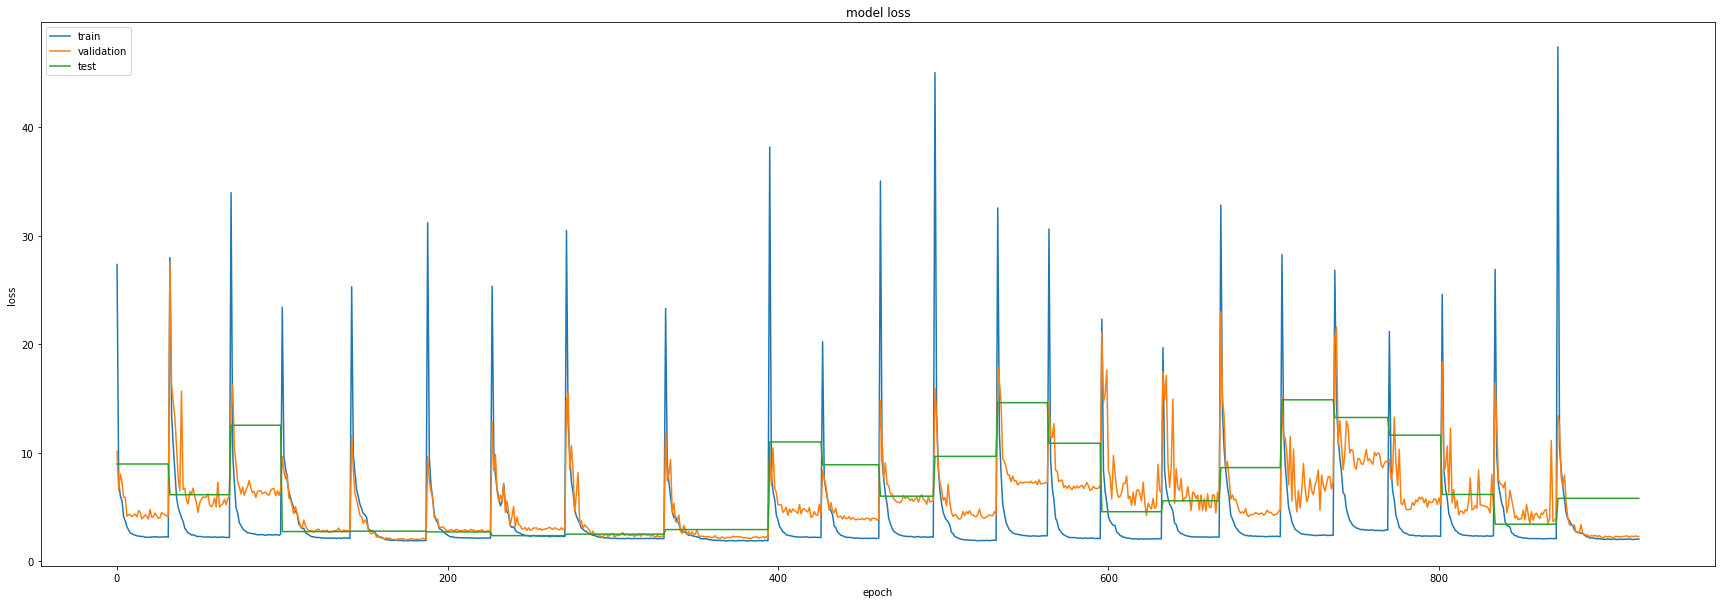

Eval Mean 6.812225692442855


In [ ]:
BAMI_Data_PPG, BAMI_Data_ACC, BAMI_Data_truth = preprocess_dataset(BAMI_Data)
train_model_loso(BAMI_Data, BAMI_Data_PPG, BAMI_Data_ACC, BAMI_Data_truth, "BAMI")

Fit model on training data fold  0
Epoch 1/200
1640/1640 [==============================] - ETA: 0s - loss: 4.7019 - mae: 9.9693
Epoch 00001: val_loss improved from inf to 3.66282, saving model to /home/jupyter/DaLia/fold0.h5
1640/1640 [==============================] - 161s 93ms/step - loss: 4.7019 - mae: 9.9693 - val_loss: 3.6628 - val_mae: 8.6621 - lr: 0.0010
Epoch 2/200
1640/1640 [==============================] - ETA: 0s - loss: 3.0648 - mae: 6.1985
Epoch 00002: val_loss improved from 3.66282 to 3.44190, saving model to /home/jupyter/DaLia/fold0.h5
1640/1640 [==============================] - 145s 88ms/step - loss: 3.0648 - mae: 6.1985 - val_loss: 3.4419 - val_mae: 8.6669 - lr: 0.0010
Epoch 3/200
1640/1640 [==============================] - ETA: 0s - loss: 2.7417 - mae: 4.9905
Epoch 00003: val_loss improved from 3.44190 to 3.00865, saving model to /home/jupyter/DaLia/fold0.h5
1640/1640 [==============================] - 155s 95ms/step - loss: 2.7417 - mae: 4.9905 - val_loss: 3.008

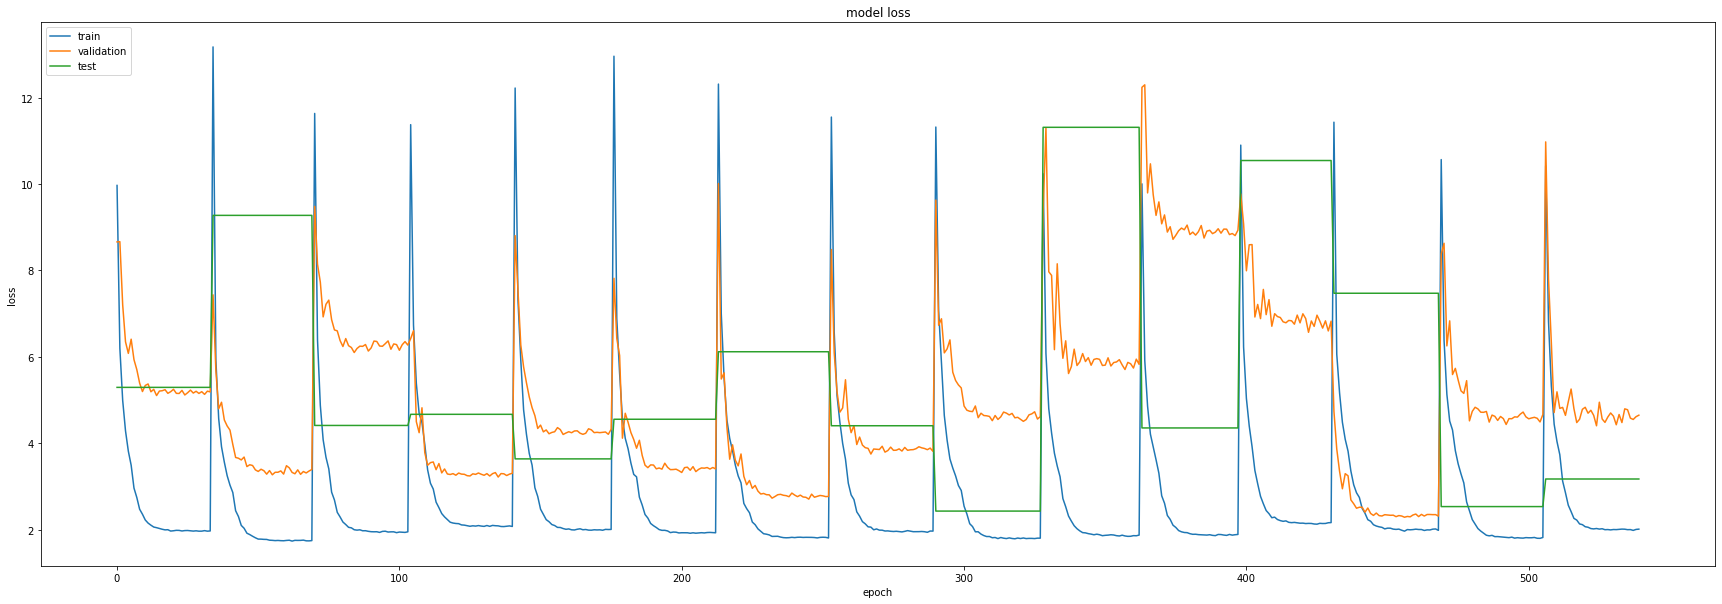

Eval Mean 5.58250825714182


In [ ]:
DaLia_Data_PPG, DaLia_Data_ACC, DaLia_Data_truth = preprocess_dataset(DaLia_Data)
train_model_loso(DaLia_Data, DaLia_Data_PPG, DaLia_Data_ACC, DaLia_Data_truth, "DaLia")

Fit model on training data fold  0
Epoch 1/200
42/42 [==============================] - ETA: 0s - loss: 67.5560 - mae: 77.5107
Epoch 00001: val_loss improved from inf to 5.89698, saving model to /home/jupyter/IEEE_Train/fold0.h5
42/42 [==============================] - 17s 161ms/step - loss: 67.5560 - mae: 77.5107 - val_loss: 5.8970 - val_mae: 19.9611 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - ETA: 0s - loss: 4.5549 - mae: 13.6913
Epoch 00002: val_loss did not improve from 5.89698
42/42 [==============================] - 4s 106ms/step - loss: 4.5549 - mae: 13.6913 - val_loss: 6.2750 - val_mae: 21.3418 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 3.7936 - mae: 10.8376
Epoch 00003: val_loss did not improve from 5.89698

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 [==============================] - 4s 103ms/step - loss: 3.7936 - mae: 10.8376 - val_loss: 6.8679 - val_mae: 23.9147 - lr: 0.0

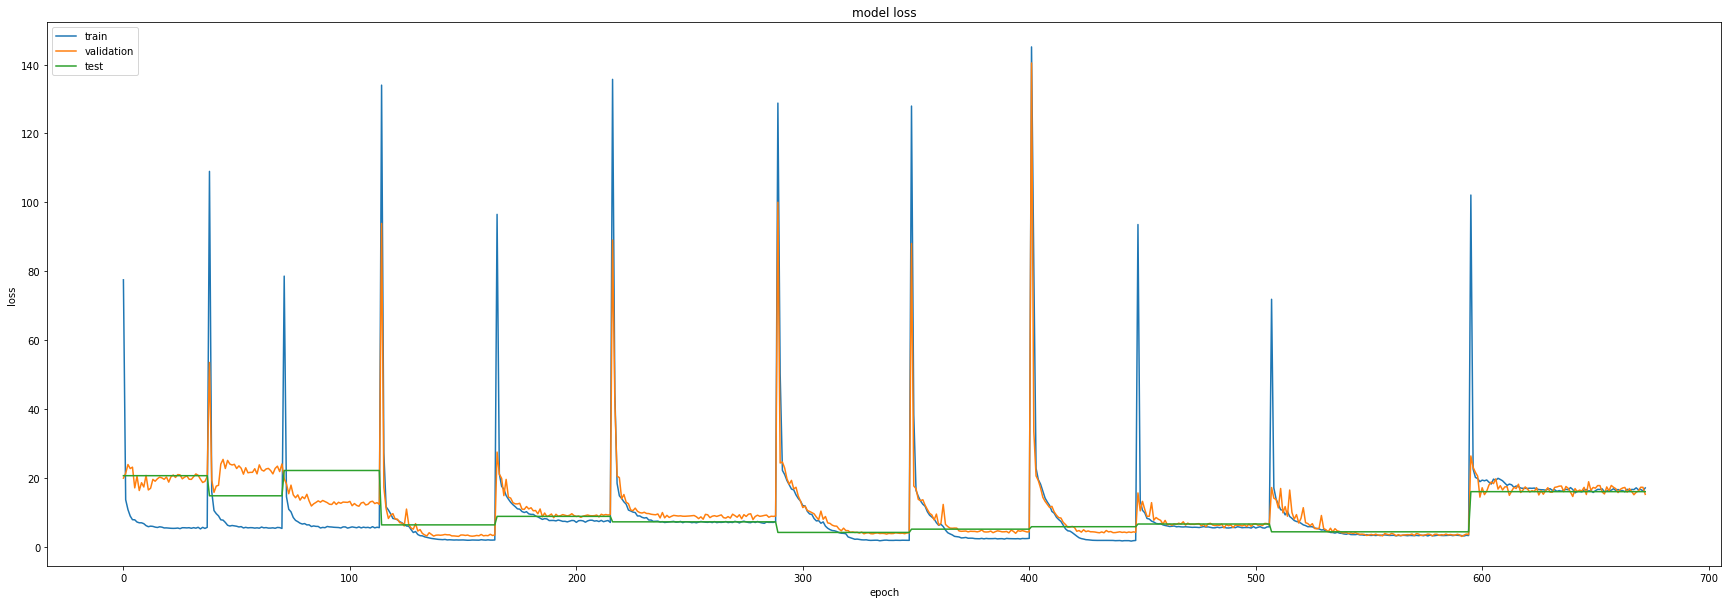

Eval Mean 9.452842766250225


In [ ]:
IEEE_Train_Data_PPG, IEEE_Train_Data_ACC, IEEE_Train_Data_truth = preprocess_dataset(IEEE_Train_Data)
train_model_loso(IEEE_Train_Data, IEEE_Train_Data_PPG, IEEE_Train_Data_ACC, IEEE_Train_Data_truth, "IEEE_Train")

Fit model on training data fold  0
Epoch 1/200
29/29 [==============================] - ETA: 0s - loss: 92.9015 - mae: 92.8783
Epoch 00001: val_loss improved from inf to 12.25428, saving model to /home/jupyter/IEEE_Test/fold0.h5
29/29 [==============================] - 15s 206ms/step - loss: 92.9015 - mae: 92.8783 - val_loss: 12.2543 - val_mae: 33.5581 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - ETA: 0s - loss: 8.3999 - mae: 28.3633
Epoch 00002: val_loss improved from 12.25428 to 7.77322, saving model to /home/jupyter/IEEE_Test/fold0.h5
29/29 [==============================] - 4s 124ms/step - loss: 8.3999 - mae: 28.3633 - val_loss: 7.7732 - val_mae: 31.5837 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - ETA: 0s - loss: 5.5469 - mae: 19.7593
Epoch 00003: val_loss improved from 7.77322 to 6.25871, saving model to /home/jupyter/IEEE_Test/fold0.h5
29/29 [==============================] - 3s 121ms/step - loss: 5.5469 - mae: 19.7593 - val_loss: 6.2587

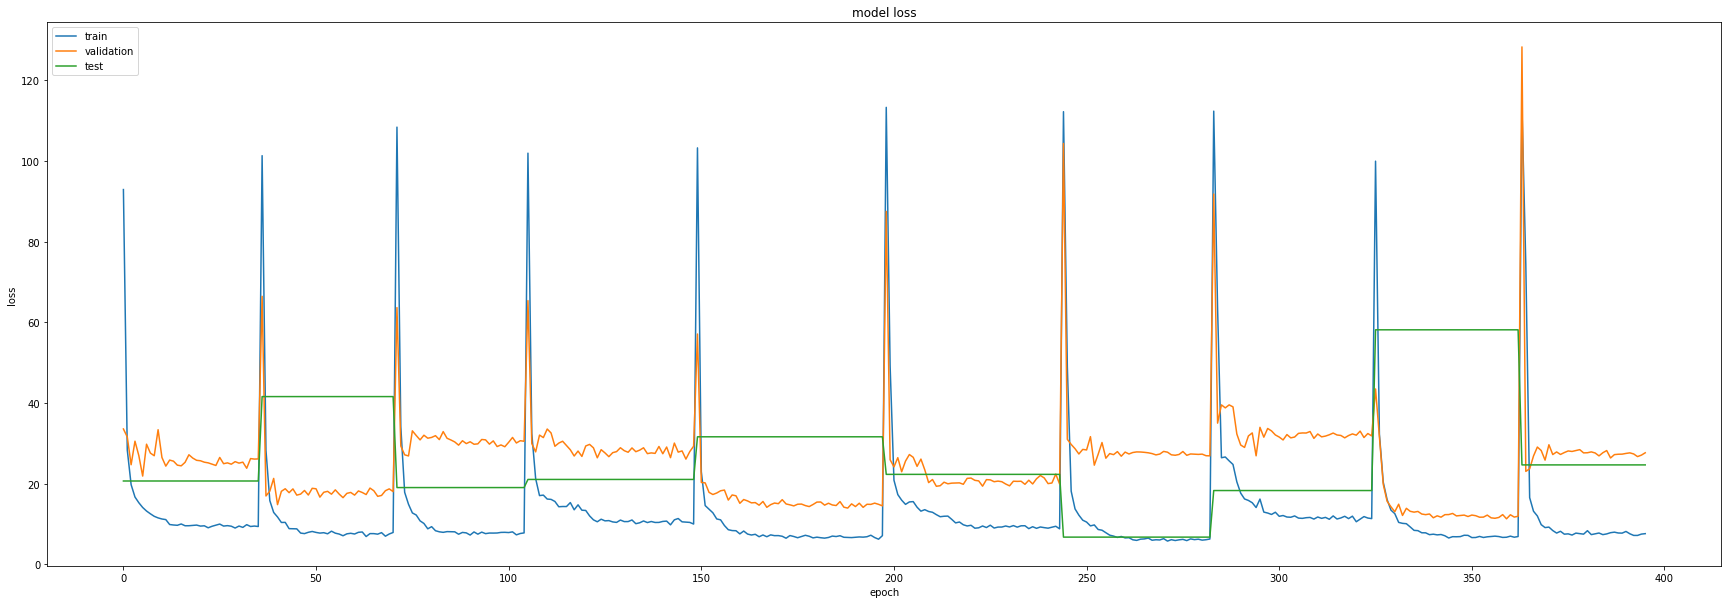

Eval Mean 26.272119064523718


In [ ]:
IEEE_Test_Data_PPG, IEEE_Test_Data_ACC, IEEE_Test_Data_truth = preprocess_dataset(IEEE_Test_Data)
train_model_loso(IEEE_Test_Data, IEEE_Test_Data_PPG, IEEE_Test_Data_ACC, IEEE_Test_Data_truth, "IEEE_Test")